In [81]:
options(repr.plot.width=8, repr.plot.height=5)
library(tidyverse)
library(nycflights13)

## &#129300; (Warmup) Quiz

```
  origin 1    2    3     4     5     6     7     8     9    10    11   12  
1 EWR    9893 9107 10420 10531 10592 10175 10475 10359 9550 10104 9707 9922
2 JFK    9161 8421  9697  9218  9397  9472 10023  9983 8908  9143 8710 9146
3 LGA    7950 7423  8717  8581  8807  8596  8927  8985 9116  9642 8851 9067
```

How could I convert this table to a tidy format? (Check all that apply)

<ol style="list-style-type: upper-alpha;">
    <li><code>pivot_longer(tbl, 1:12)</code></li>
    <li><code>mutate(tbl, year=.column)</code></li>
    <li><code>summarize(tbl, year)</code></li>
    <li><code>pivot_longer(tbl, 2:13)</code></li>
    <li><code>pivot_longer(tbl, -origin)</code></li>
</ol>

In [37]:
# solution
tbl <- flights %>% count(origin, month) %>% pivot_wider(names_from = month, values_from = n)
pivot_longer(tbl, -origin)
tbl

origin,1,2,3,4,5,6,7,8,9,10,11,12
<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
EWR,9893,9107,10420,10531,10592,10175,10475,10359,9550,10104,9707,9922
JFK,9161,8421,9697,9218,9397,9472,10023,9983,8908,9143,8710,9146
LGA,7950,7423,8717,8581,8807,8596,8927,8985,9116,9642,8851,9067


# Lecture 5: Tidy data, missing data

<div style="border: 1px double black; padding: 10px; margin: 10px">

**After today's lecture you will:**
* Gain more experience creating and working with tidy data
* Learn about how R handles missing data.
    
This lecture note corresponds to Chapters 6 and 20 of your book. 
</div>


    




## Questions from Piazza and e-mail
- "I don't understand how `pivot_wider()` works"

## How `pivot_wider()` works
Here's a simple untidy dataset:

In [47]:
df <- tribble(
  ~id, ~name, ~value,
  "A", "x", 1,
  "B", "y", 2,
  "B", "x", 3, 
  "A", "y", 4,
  "A", "z", 5,
)

In [41]:
df

id,name,value
<chr>,<chr>,<dbl>
A,x,1
B,y,2
B,x,3
A,y,4
A,z,5


(Why is it untidy?)

In [8]:
# First how do we make df tidy?

Here's how `pivot_wider()` got this answer:

First, we have to figure out what are the new column names:

In [44]:
# figure out all the new column names
df %>% distinct(name)

name
<chr>
x
y
z


Next, we have to figure out all the rows that will exist in the new tabel. 
By default, the rows in the output are formed by all the variables that aren’t going into the names or values. 
(These are called the id_cols.)

In [53]:
# figure out all the new rows
df <- tribble(
  ~id, ~x, ~y, ~y,
  "A", NA, NA, NA,
  "B", NA, NA, NA
)

df

id,x,y,y
<chr>,<lgl>,<lgl>,<lgl>
A,NA,NA,NA
B,NA,NA,NA


Finall, we have to fill in all the empty cells of this table by looking them up in the original table.

## A usage of `pivot_wider()`
Let's revisit the `gapminder` dataset that we first saw last lecture:

In [91]:
library(gapminder)
print(gapminder)

# A tibble: 1,704 × 6
   country     continent  year lifeExp      pop gdpPercap
   <fct>       <fct>     <int>   <dbl>    <int>     <dbl>
 1 Afghanistan Asia       1952    28.8  8425333      779.
 2 Afghanistan Asia       1957    30.3  9240934      821.
 3 Afghanistan Asia       1962    32.0 10267083      853.
 4 Afghanistan Asia       1967    34.0 11537966      836.
 5 Afghanistan Asia       1972    36.1 13079460      740.
 6 Afghanistan Asia       1977    38.4 14880372      786.
 7 Afghanistan Asia       1982    39.9 12881816      978.
 8 Afghanistan Asia       1987    40.8 13867957      852.
 9 Afghanistan Asia       1992    41.7 16317921      649.
10 Afghanistan Asia       1997    41.8 22227415      635.
# … with 1,694 more rows


I want to study GDP per capita over time. If I plot **all** the data, I get something that looks like:

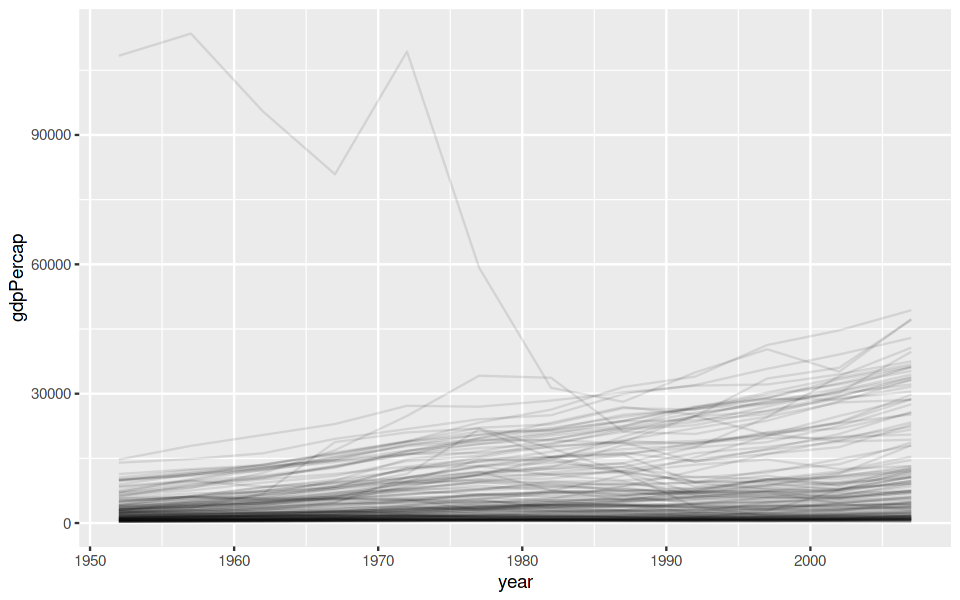

In [63]:
gapminder %>% 
    ggplot(aes(x = year, y = gdpPercap, group = country)) + 
    geom_line(alpha=0.1)

Looking at all the data simultaneousy is too overwhelming. So, I'm going to summarize the data in a particular way. As a first step, we are going convert each country into a data point (row) containing all of its data side-by-side:

In [66]:
# convert gapminder to wide, placing different years of data side-by-side
col_year <- gapminder %>% select(country, year, gdpPercap) %>% 
    pivot_wider(names_from = year, values_from = gdpPercap)

Now `col_year` is a **data frame** that contains one observation per row. This enables us to ask questions about **covariation** between the data in different years.

In [69]:
# example of covariation between two different years

col_year %>% summarize(cov(`1952`, `1957`))

"cov(`1952`, `1957`)"
<dbl>
91842671


## &#129300; Quiz

The correlation between a country's GDP per capita in 1952 and 2002 was:

<ol style="list-style-type: upper-alpha;">
    <li>0.0</li>
    <li>-.21</li>
    <li>1.65</li>
    <li>44822176</li>
    <li>.43</li> 
</ol>

Finally, we'll do one more trick, following Chapter 6 of the book. We will **cluster** these data in order to organize the countries into a few (hopefully) interpretable groups. 

For technical reasons, in order to do clustering, we need to convert our data frame slightly by using a function called `columns_to_rownames()`:

In [79]:
# use `columns_to_rownames()` to create a base R data frame with named rows.

col_year_df <- column_to_rownames(col_year, "country")

In [93]:
col_year_df <- column_to_rownames(col_year, "country")
cluster <- stats::kmeans(col_year_df, centers = 6)
cluster

K-means clustering with 6 clusters of sizes 34, 19, 1, 19, 55, 14

Cluster means:
        1952        1957      1962      1967       1972      1977      1982
1   2234.983   2504.1647  2765.586  3223.494   3713.196  4155.411  4500.970
2   8503.855  10135.4171 11919.636 14456.124  17853.169 20366.813 22012.196
3 108382.353 113523.1329 95458.112 80894.883 109347.867 59265.477 31354.036
4   4133.176   5125.4905  5995.587  7721.618   9255.743 11327.370 10863.945
5    872.776    950.2704  1017.610  1092.327   1218.631  1273.500  1298.311
6   4036.511   4973.5097  6087.107  7623.569  10261.514 11834.870 13374.517
       1987      1992      1997      2002      2007
1  4636.425  4775.865  5433.720  5858.195  7071.099
2 24009.718 25920.095 28519.263 31329.977 35358.248
3 28118.430 34932.920 40300.620 35110.106 47306.990
4 10060.262  8354.337  9066.222  9554.434 12267.911
5  1267.235  1232.894  1257.573  1331.194  1583.415
6 15653.304 17299.051 20176.223 23144.734 27061.499

Clustering vector:
  

Finally, we assign each country back to its cluster:

In [52]:
cluster_id <- cluster$cluster  %>% 
  enframe()  %>% 
  rename(country = name, cluster_id = value) %>% print

# A tibble: 142 × 2
   country     cluster_id
   <chr>            <int>
 1 Afghanistan          4
 2 Albania              1
 3 Algeria              1
 4 Angola               1
 5 Argentina            3
 6 Australia            5
 7 Austria              5
 8 Bahrain              5
 9 Bangladesh           4
10 Belgium              5
# … with 132 more rows


Joining, by = "country"
`summarise()` has grouped output by 'cluster_id'. You can override using the
`.groups` argument.


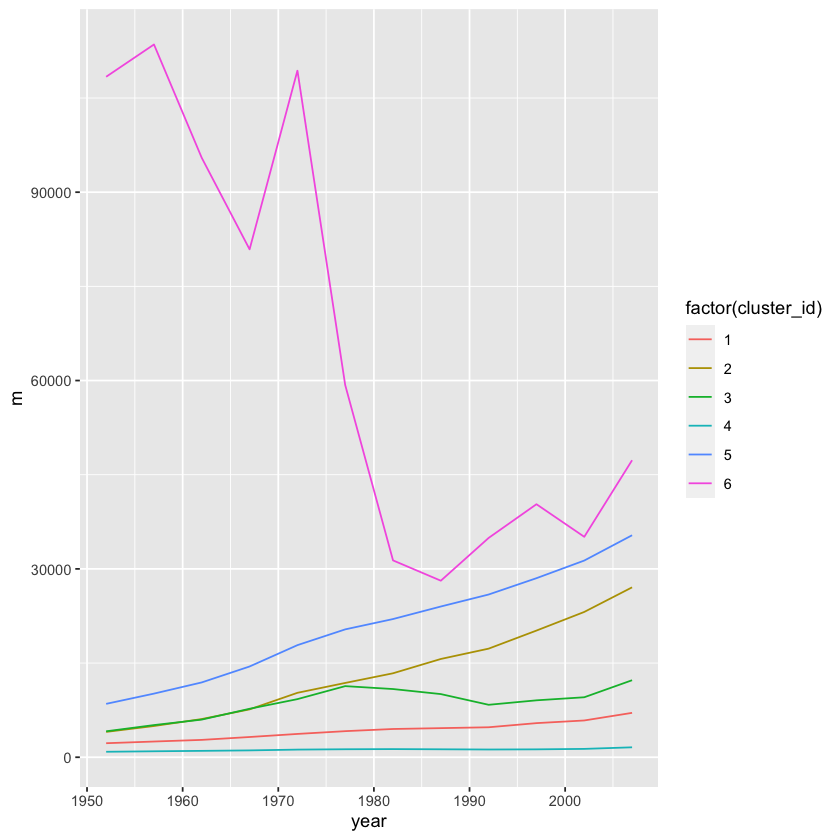

In [61]:
# plot mean gdppercap for each country in each cluster

In [18]:
print(table2)

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


## Missing data in R
The `gapminder` appears very nice, it only contains data sets with no missing observations. But! The raw data looks like this:

In [94]:
gapminder_unfiltered  %>% print

# A tibble: 3,313 × 6
   country     continent  year lifeExp      pop gdpPercap
   <fct>       <fct>     <int>   <dbl>    <int>     <dbl>
 1 Afghanistan Asia       1952    28.8  8425333      779.
 2 Afghanistan Asia       1957    30.3  9240934      821.
 3 Afghanistan Asia       1962    32.0 10267083      853.
 4 Afghanistan Asia       1967    34.0 11537966      836.
 5 Afghanistan Asia       1972    36.1 13079460      740.
 6 Afghanistan Asia       1977    38.4 14880372      786.
 7 Afghanistan Asia       1982    39.9 12881816      978.
 8 Afghanistan Asia       1987    40.8 13867957      852.
 9 Afghanistan Asia       1992    41.7 16317921      649.
10 Afghanistan Asia       1997    41.8 22227415      635.
# … with 3,303 more rows


What happens when we reshape the "unfiltered" data?

In [97]:
# pivot unfiltered data wider

gapminder_unfiltered %>% filter(country == "Armenia")

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Armenia,FSU,1992,68.663,3378331,1442.938
Armenia,FSU,1997,70.377,3059000,1791.347
Armenia,FSU,2002,71.403,3013818,2692.304
Armenia,FSU,2007,71.965,2971650,4942.544


You can see that there are many missing observations in the unfiltered data. In real life, you will mostly get unfiltered data -- how should we handle missing data?

## Missing Values
Missing values can be:

* **Explicit** (marked as `NA` in our data); or
* **Implicit** (not present in the data).

In [99]:
treatment <- tribble(
  ~person,           ~treatment, ~response,
  "Derrick Whitmore", 1,         7,
  NA,                 2,         10,
  NA,                 3,         NA,
  "Katherine Burke",  1,         4
)

In [100]:
treatment

person,treatment,response
<chr>,<dbl>,<dbl>
Derrick Whitmore,1,7
NA,2,10
NA,3,NA
Katherine Burke,1,4


The missing values are **explicit** in this table: each missing value is indicated by `NA` in the table.

You can fill in these missing values with `tidyr::fill()`. It works like `select()`, taking a set of columns, and fills them in with the last non-missing value.

In [109]:
# fill in each missing value in gapminder_unfiltered carrying forward

gapminder_unfiltered %>% fill(gdpPercap)

country,continent,year,lifeExp,pop,gdpPercap
<fct>,<fct>,<int>,<dbl>,<int>,<dbl>
Afghanistan,Asia,1952,28.801,8425333,779.4453
Afghanistan,Asia,1957,30.332,9240934,820.8530
Afghanistan,Asia,1962,31.997,10267083,853.1007
Afghanistan,Asia,1967,34.020,11537966,836.1971
Afghanistan,Asia,1972,36.088,13079460,739.9811
Afghanistan,Asia,1977,38.438,14880372,786.1134
Afghanistan,Asia,1982,39.854,12881816,978.0114
Afghanistan,Asia,1987,40.822,13867957,852.3959
Afghanistan,Asia,1992,41.674,16317921,649.3414


## Encoded missing data

Sometimes, data contain a concrete value that actually represents a missing value. You see this often when dealing with data that is imported from a format that does not have a way to represent missing values, such as text or CSV. So it must instead use some special value like 99 or -999.

## Example: Billionaires
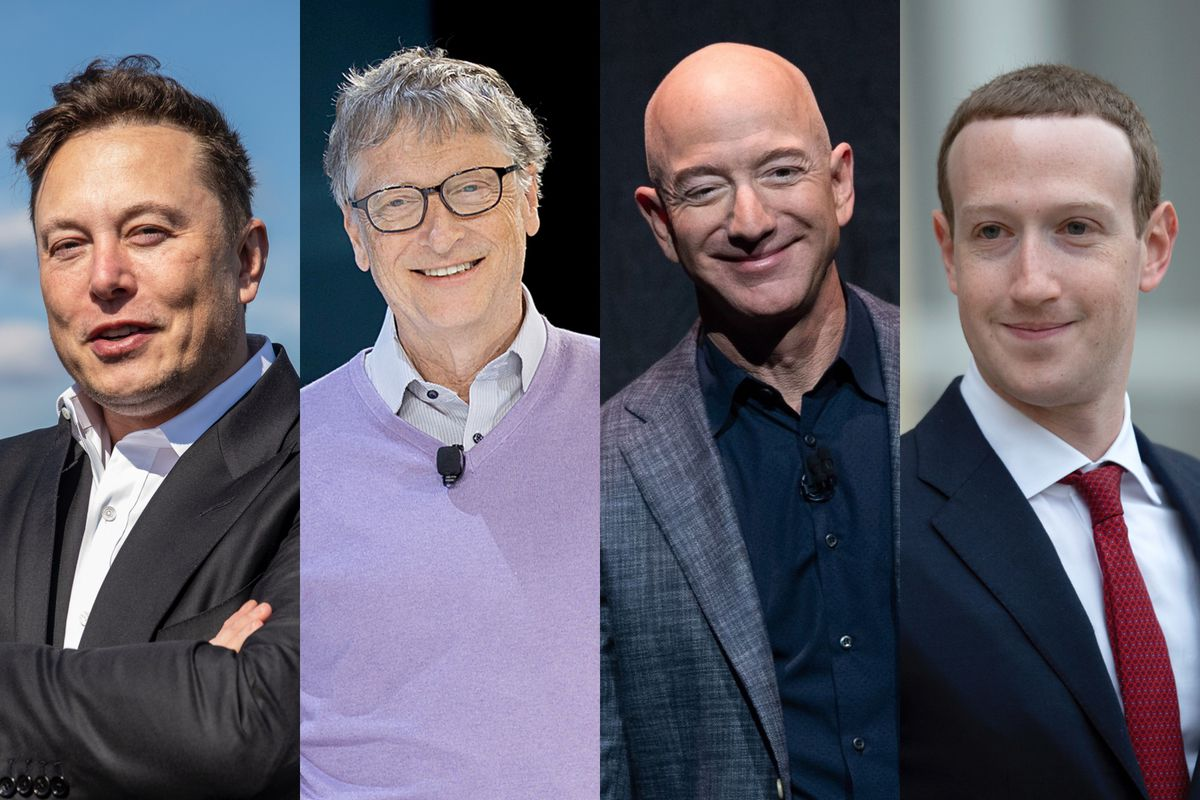

The following command loads a dataset called "bil", which contains information on the world's billionaires:

In [123]:
# load(url("https://datasets.stats306.org/bil.RData"))
bil  # %>% filter(age > 0) %>% summarize(mean(age))

age,category,citizenship,company.name,company.type,country code,founded,from emerging,gdp,gender,⋯,name,rank,region,relationship,sector,was founder,was political,wealth.type,worth in billions,year
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,⋯,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
-1,Financial,Saudi Arabia,Rolaco Trading and Contracting Company,new,SAU,1968,True,1.580000e+11,male,⋯,Abdul Aziz Al-Sulaiman,404,Middle East/North Africa,founder,construction,True,False,self-made finance,1.0,1996
34,Financial,United States,Fidelity Investments,new,USA,1946,True,8.100000e+12,female,⋯,Abigail Johnson,145,North America,relation,investment banking,True,False,inherited,2.5,1996
59,Non-Traded Sectors,Brazil,Companhia Brasileira de Distribui?ao,new,BRA,1948,True,8.540000e+11,male,⋯,Abilio dos Santos Diniz,322,Latin America,relation,retail,True,False,inherited,1.2,1996
61,New Sectors,Germany,Ratiopharm,new,DEU,1881,True,2.500000e+12,male,⋯,Adolf Merckle,388,Europe,relation,pharmaceuticals,True,False,inherited,1.0,1996
-1,Financial,Hong Kong,Swire,new,HKG,1816,True,1.600000e+11,male,⋯,Adrian and John Swire,162,East Asia,relation,trading company,True,False,inherited,2.2,1996
-1,Traded Sectors,Bahrain,YBA Kanoo,new,BHR,1890,True,6.100000e+09,male,⋯,Ahmed Ali Kanoo,383,Middle East/North Africa,relation,shipping,True,True,inherited,1.0,1996
-1,New Sectors,Japan,Otsuka Holdings,new,JPN,1921,True,4.710000e+12,male,⋯,Akihiko Otsuka,164,East Asia,relation,pharmaceuticals,True,False,inherited,2.2,1996
-1,Traded Sectors,Japan,Sony,new,JPN,1946,True,4.710000e+12,male,⋯,Akio Morita,156,East Asia,founder,technology,True,False,founder non-finance,2.3,1996
66,Financial,Japan,Mori Building,new,JPN,1959,True,4.710000e+12,male,⋯,Akira Mori,60,East Asia,relation,construction,True,False,inherited,3.9,1996


## &#129300; Quiz

The average age of a billionaire in this dataset is:

<ol style="list-style-type: upper-alpha;">
    <li>28.1</li>
    <li>Something else/cannot be determined</li>
    <li>53.2</li>
    <li>78.3</li>
    <li>62.6</li> 
</ol>

To correct for this type of missing value, we can use a function called `na_if(x, n)`. This takes a vector `x` and replaces any occurence of `n` with `NA`:

In [122]:
bil %>% mutate(age = na_if(age, -1)) %>% summarize(mean(age, na.rm=T))

"mean(age, na.rm = T)"
<dbl>
62.57649


In [27]:
# use na_if to mark missing values in bil

## Implicit missing values
A second type of missing data occurs when there are simply no observations in the dataset for a particular combination of columns. For example:

In [125]:
stocks <- tibble(
  year  = c(2020, 2020, 2020, 2020, 2021, 2021, 2021),
  qtr   = c(   1,    2,    3,    4,    2,    3,    4),
  price = c(1.88, 0.59, 0.35,   NA, 0.92, 0.17, 2.66)
)

In [126]:
print(stocks)

# A tibble: 7 × 3
   year   qtr price
  <dbl> <dbl> <dbl>
1  2020     1  1.88
2  2020     2  0.59
3  2020     3  0.35
4  2020     4 NA   
5  2021     2  0.92
6  2021     3  0.17
7  2021     4  2.66


This dataset has two missing observations:
- The price in the 2020q4 is explicitly missing. (It has an `NA`.)
- The price in 2021q1 is implicitly missing: it does not appear in the dataset.

> An explicit missing value is the presence of an absence.
>
> An implicit missing value is the absence of a presence.


How can we handle implicit missing values? As we have already seen, one option is to use `pivot_wider()`:

In [128]:
# using pivot_wider() on stocks converts implicit missing values to explicit

stocks %>% pivot_wider(names_from = qtr, values_from = price)

year,1,2,3,4
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020,1.88,0.59,0.35,NA
2021,NA,0.92,0.17,2.66


Alternatively, we can use the `complete()` function, which creates entries for all possible combinations of a set of columns:

In [130]:
# use complete to fill in missing values for stocks

stocks %>% complete(year, month, day)

year,qtr,price
<dbl>,<dbl>,<dbl>
2020,1,1.88
2020,2,0.59
2020,3,0.35
2020,4,NA
2021,1,NA
2021,2,0.92
2021,3,0.17
2021,4,2.66


## Example: Climate data

The [Global Historical Climate Network](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) is amazing database of daily weather data going back, in some cases, >100 years. I downloaded daily observation data for Ann Arbor from 1991 to present:

Questions about these data:
- What do the columns mean? 
- What are the units? How can we find this information out?
- How is missing data indicated?
- What questions can we ask about these data?
  - Are the data in an appropriate format to answer these questions?
  - If not, how can we get them there?

In [141]:
# load(url('https://datasets.stats306.org/a2weather.RData'))

a2weather %>% filter(month == 1, element ==  "SNOW") %>% select(year, month, VALUE25) %>% 
    summarize(mean(VALUE25, na.rm=T))

"mean(VALUE25, na.rm = T)"
<dbl>
10.73643
